In [1]:
import pandas as pd
import numpy as np
from glob import  glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import json
import matplotlib.pyplot as plt

import xarray as xr

In [2]:
names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']

target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
paths = glob('data/raw/*')

responses = dict()

dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        values = [d.split(':')[-1].replace('\n','')[1:] for d in data[:9]]
        cfg = dict(zip(names, values))
    # encoding='latin-1', sep=';', decimal=',', na_values=['-9999.0'], 
    df = pd.read_csv(p, sep=';', na_values=['-9999.0'], skiprows=9)
    #pd.read_csv(p, encoding='latin-1', sep=';', na_values=['-9999.0'], skiprows=9)
    for name, value in cfg.items():
        df[name] = value

    #if cfg['cod'] in ['83897', '83836', '83842', '83767', '83766']:
    #    print('pass: ', cfg['cod'])
    #    continue
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df[(df.index.day==29) & (df.index.month==2)] = np.nan
    df_combined = df_times.combine_first(df)

    main_df = df_combined[['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)']]

    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df_combined['percent_null'] = round(float(percent_null), 1)
    df_combined = df_combined.sort_values('index')

    if percent_null < 12:       
        dfs.append(df_combined)  

df_concat = pd.concat(dfs)

codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, codes=codes, percent_null=percent_null))

In [3]:
dfs = list()
for i, code in enumerate(codes):
    df_code = df_concat[df_concat['cod']==code]
    info = df_code.iloc[:, [-1, -3, -10]]
    df_code = df_code.assign(tmean=df_code['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)'])
    #df_code.assign(tmean=df_code.iloc[:, [4,6]].mean(axis=1))
    df_code['tmean'] = df_code['tmean'].fillna(df_code['tmean'].mean())
    df_final = pd.concat([info, df_code['tmean']], axis=1).reset_index()
    _df = pd.DataFrame({code:df_final['tmean'].values}, index=df_final['index']).T
    dfs.append(_df)
    
#dfs = [_.iloc[1:] for _ in dfs]

data2group = pd.DataFrame([df.values.ravel() for df in dfs], columns=[str(c).split(' ')[0] for c in _df.columns], index=[str(df.index[0]) for df in dfs])
data2group = data2group.reset_index()
idx2code = data2group['index'].to_dict()

data = data2group.iloc[:, 1:]
data.iloc[8,:] = data.iloc[8,:].fillna(data.iloc[8,:].mean())
data.iloc[15,:] = data.iloc[8,:].fillna(data.iloc[15,:].mean())

In [4]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Dendograma')
        plt.xlabel('Índices')
        plt.ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [24]:
data

,1991-01-01,1991-01-02,1991-01-03,1991-01-04,1991-01-05,1991-01-06,1991-01-07,1991-01-08,1991-01-09,1991-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
0,16.917660,16.917660,16.917660,16.917660,16.917660,16.917660,16.917660,16.917660,16.917660,16.917660,...,17.800000,20.300000,22.600000,21.000000,21.800000,20.800000,20.800000,23.000000,25.300000,21.000000
1,22.500000,23.000000,23.300000,23.100000,22.800000,22.400000,22.800000,22.500000,21.200000,20.200000,...,21.000000,23.200000,24.400000,24.000000,23.900000,24.000000,24.300000,24.600000,25.300000,24.100000
2,23.200000,23.400000,20.400000,19.500000,20.100000,22.100000,23.300000,24.600000,25.200000,23.000000,...,17.573455,17.573455,17.573455,17.573455,17.573455,17.573455,17.573455,17.573455,17.573455,17.573455
3,24.100000,26.200000,23.200000,21.900000,22.300000,23.500000,24.600000,25.800000,27.300000,24.100000,...,21.500000,23.500000,25.500000,25.200000,25.100000,24.700000,25.400000,26.400000,28.800000,24.000000
4,25.300000,25.000000,22.600000,21.300000,21.800000,24.300000,25.900000,27.900000,26.100000,24.700000,...,20.100000,22.800000,26.200000,25.700000,24.300000,23.700000,25.200000,25.700000,24.500000,19.700000
5,23.800000,24.300000,21.300000,20.300000,21.000000,22.200000,23.600000,24.300000,25.500000,23.600000,...,19.300000,21.100000,24.000000,23.800000,23.600000,24.600000,23.900000,23.800000,25.800000,20.800000
6,23.300000,21.800000,20.000000,20.700000,20.800000,21.100000,22.300000,23.600000,22.900000,22.500000,...,17.800000,20.800000,22.900000,23.400000,23.100000,17.048042,22.900000,24.200000,24.900000,19.200000
7,17.600000,20.000000,20.000000,19.000000,17.300000,17.700000,18.400000,19.700000,20.800000,20.700000,...,19.300000,19.800000,19.000000,19.000000,19.600000,17.787653,21.600000,21.700000,24.400000,22.900000
8,22.100000,24.600000,24.600000,22.800000,22.900000,22.800000,23.500000,25.100000,24.900000,25.300000,...,21.133425,21.133425,21.133425,21.133425,21.133425,21.133425,21.133425,21.133425,21.133425,21.133425
9,21.802300,21.802300,21.802300,21.802300,21.802300,21.802300,21.802300,21.802300,21.802300,21.802300,...,26.200000,25.800000,25.600000,24.200000,25.200000,24.200000,24.500000,21.800000,24.700000,25.000000


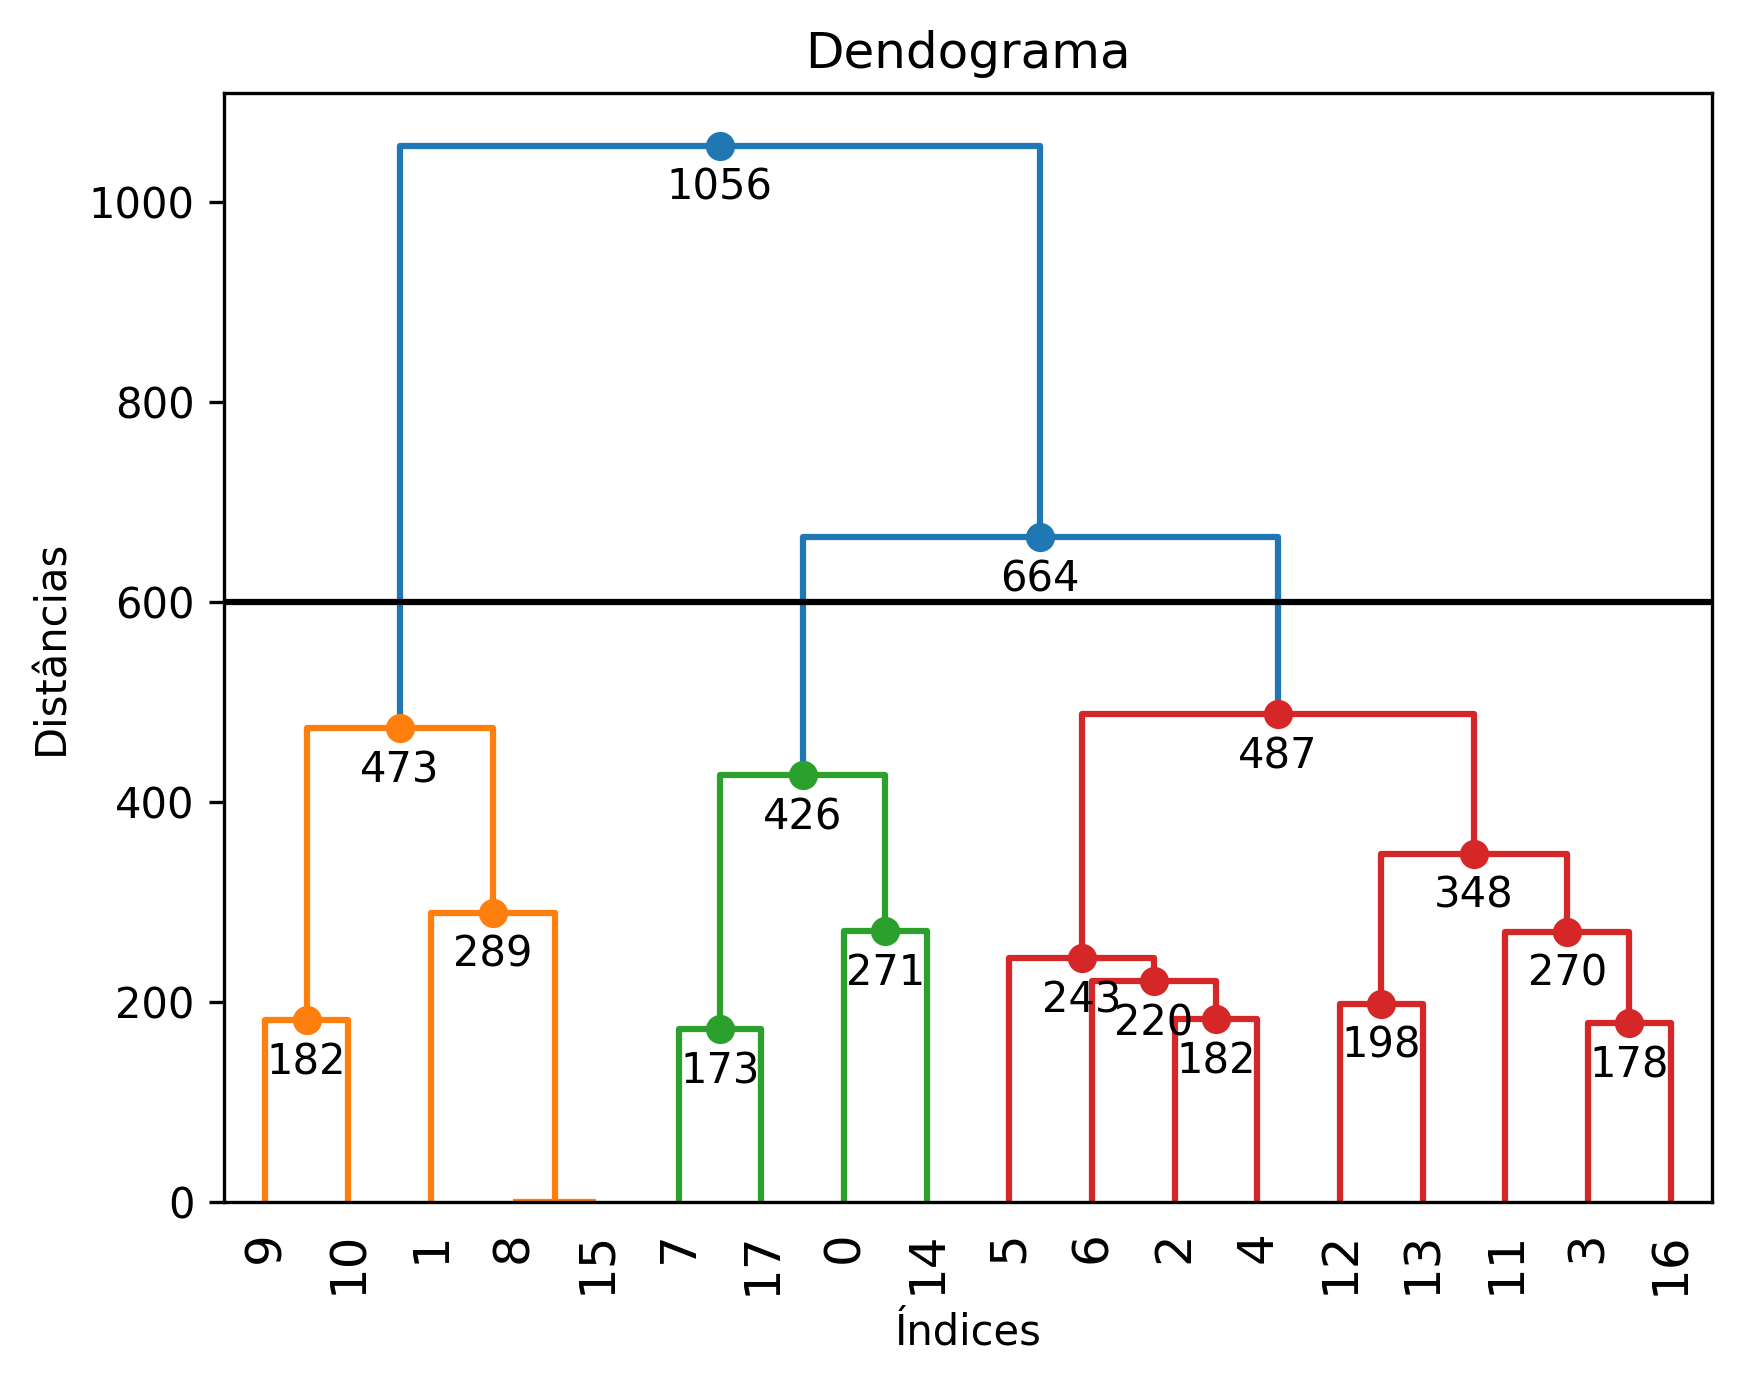

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

max_d = 600
Z = linkage(pdist(data.values), 'ward')
clusters = fcluster(Z,max_d,criterion='distance')

fig = plt.figure(dpi=300)
D = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)
plt.savefig('dendogram.png')
plt.show()

In [21]:
colors = {'C1': 'blue', 'C2': 'orange', 'C3': 'green'} #, 'C4': 'purple', 'C5': 'brown', 'C6':'pink'}
codes = [idx2code.get(int(ivl)) for ivl in D['ivl']]
groups = D['leaves_color_list']
codes2group = dict(zip(codes, groups))
codes2color = {k:colors.get(v) for k, v in codes2group.items()}

def get_groups(group):
    return [k for k, v in codes2group.items() if v == group]

g1 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C1')], axis=0)
g2 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C2')], axis=0)
g3 = np.nanmean([data2group[data2group['index'] == g].iloc[:,1:].values[0] for g in get_groups('C3')], axis=0)

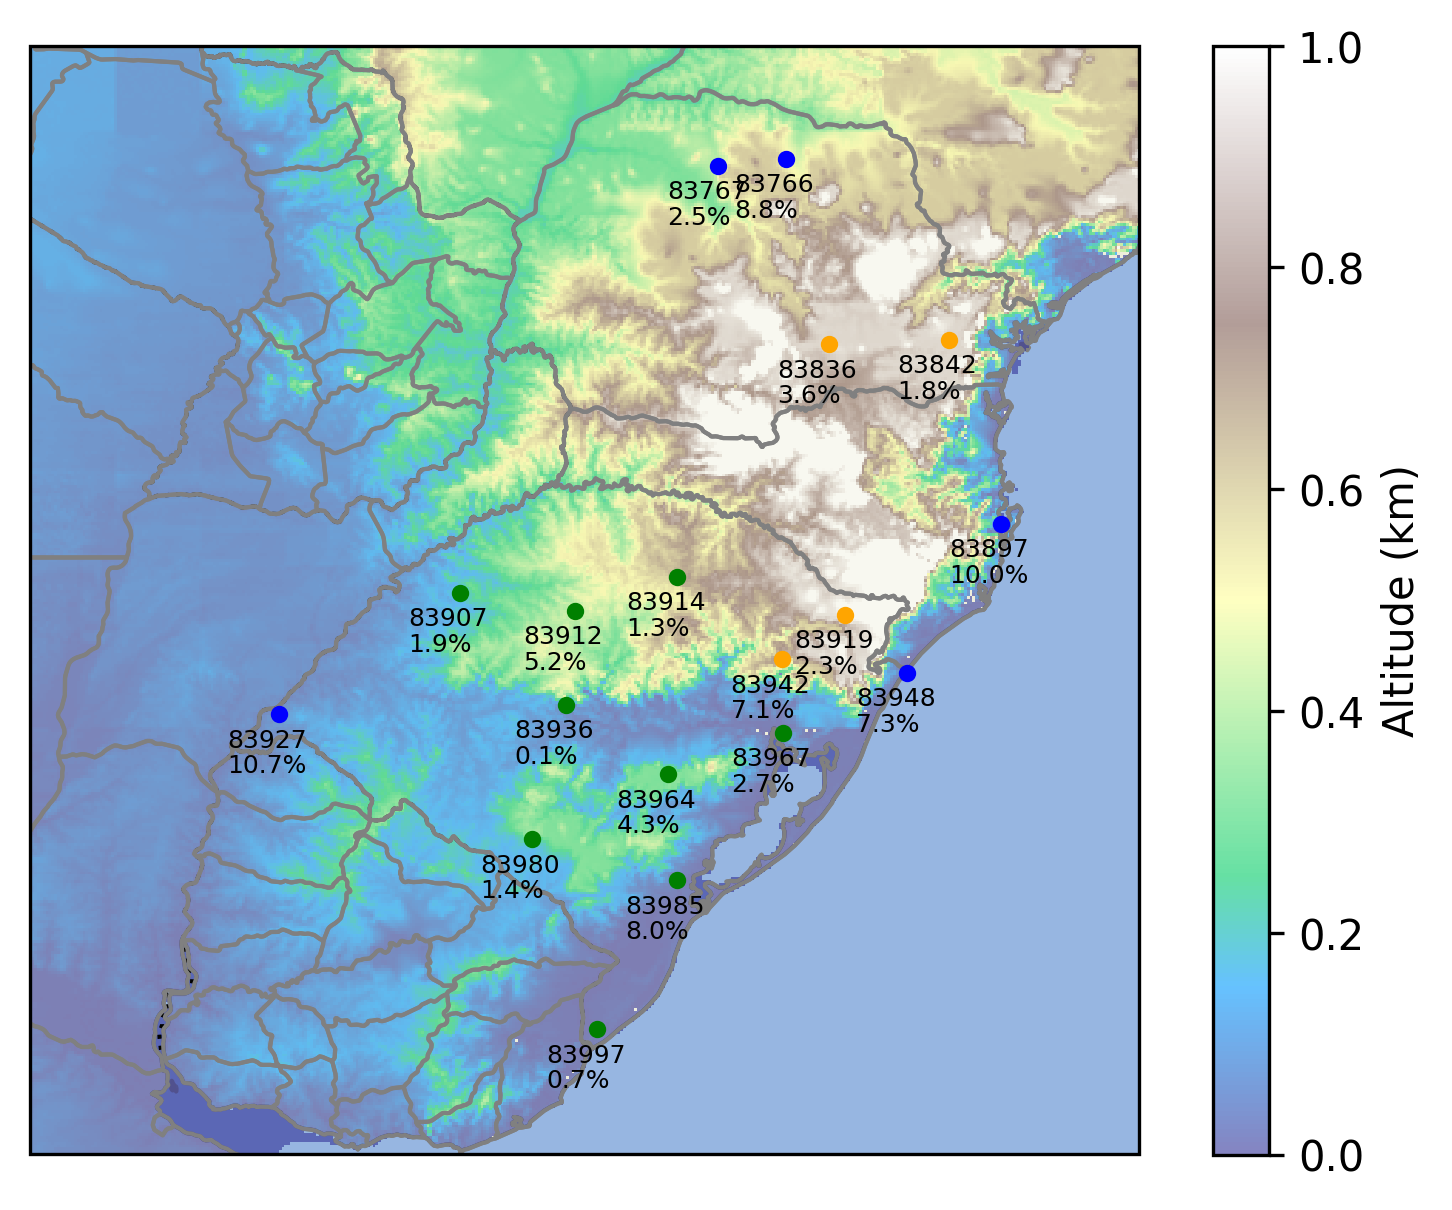

In [22]:
etopo = xr.open_dataset("/media/lucaspc/HD/statics/etopo_0p01.nc")
etopo = xr.where(etopo<0, np.nan, etopo)
etopo = xr.where(etopo>1000, 1000, etopo)

fig = plt.figure(dpi=300)

ax = plt.axes(projection=ccrs.PlateCarree())
extent = [-60, -47, -35, -22]
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.OCEAN, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='gray')
etopo = etopo['z'] / 1000
cb = etopo.plot(ax=ax, cmap='terrain', alpha=0.6, add_colorbar=False)
plt.colorbar(cb, ax=ax, label='Altitude (km)')


marker = 'o'
for idx, row in cidades.iterrows():
    
    color = codes2color.get(row['codes'])
        
    ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
          color=color, s=10, zorder=5, marker=marker)
    ax.text(row['lons']-0.6, row['lats']-0.6, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=6, 
            color='black', zorder=100,
            verticalalignment='center')
    ax.text(row['lons']-0.6, row['lats']-0.3, row['codes'],
            transform=ccrs.PlateCarree(),
            fontsize=6,
            color='black',
            verticalalignment='center')
plt.savefig('stations.png')
plt.show()

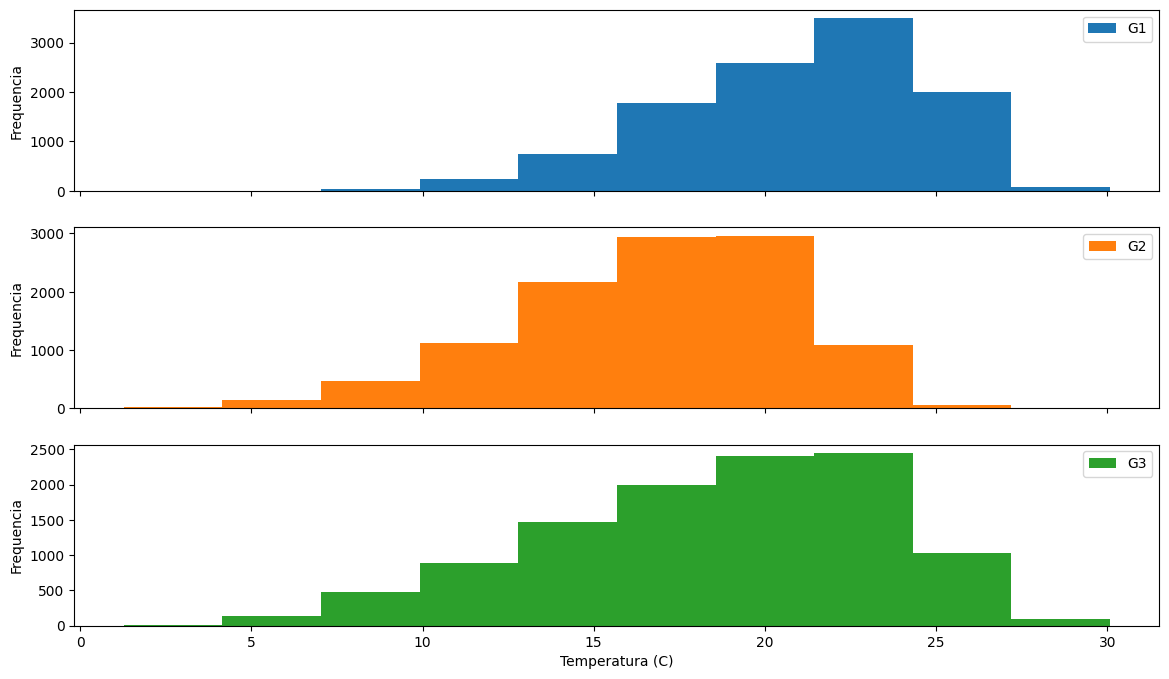

In [23]:
df_groups = pd.DataFrame({'G1':g1,'G2':g2,'G3':g3})
df_groups.plot.hist(subplots=True, figsize=(14,8), ylabel='Frequencia', xlabel='Temperatura (C)');
plt.savefig('histo.png')